In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


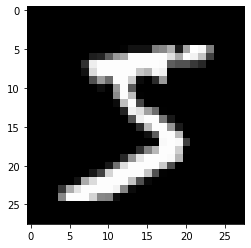

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 1, 6, 1, 3, 6, 4, 7, 8, 8, 4, 2, 0, 5, 3, 4, 0, 3, 0, 2, 1, 1, 8, 8,
        5, 4, 6, 8, 3, 8, 9, 5, 8, 5, 9, 8, 9, 6, 2, 9, 8, 0, 5, 7, 8, 7, 6, 6,
        1, 8, 9, 8, 2, 9, 1, 6, 0, 3, 6, 9, 2, 8, 5, 3, 1, 5, 4, 9, 3, 5, 4, 0,
        5, 1, 2, 5, 1, 4, 2, 6, 4, 6, 3, 1, 4, 5, 6, 1, 7, 4, 3, 4, 8, 2, 3, 7,
        3, 1, 6, 7])


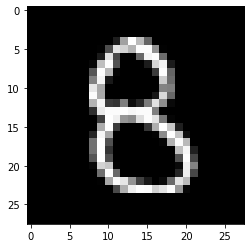

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
D.to(device);

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

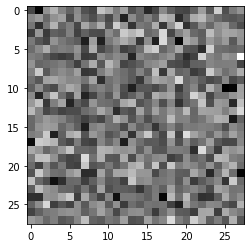

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

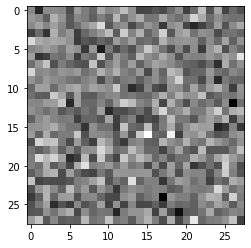

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

In [17]:
G.to(device);

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

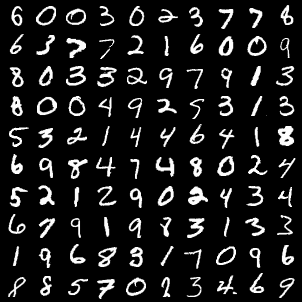

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


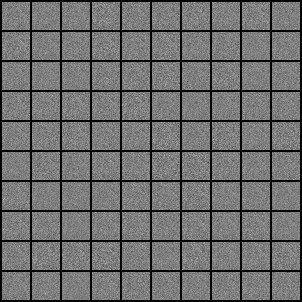

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [25]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0503, g_loss: 3.9900, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0836, g_loss: 4.9694, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0685, g_loss: 4.9799, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0248, g_loss: 5.1329, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.7418, g_loss: 2.2796, D(x): 0.79, D(G(z)): 0.27
Epoch [1/300], Step [600/600], d_loss: 0.4655, g_loss: 4.5831, D(x): 0.81, D(G(z)): 0.07
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1582, g_loss: 3.6962, D(x): 0.97, D(G(z)): 0.12
Epoch [2/300], Step [400/600], d_loss: 0.8000, g_loss: 2.2299, D(x): 0.75, D(G(z)): 0.25
Epoch [2/300], Step [600/600], d_loss: 0.8892, g_loss: 1.7714, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.2590, g_loss: 2.0369, D(x): 0.64, D(G(z)): 0.23
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.2610, g_loss: 5.0044, D(x): 0.91, D(G(z)): 0.07
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5077, g_loss: 3.9954, D(x): 0.89, D(G(z)): 0.13
Epoch [28/300], Step [400/600], d_loss: 0.3567, g_loss: 3.5995, D(x): 0.89, D(G(z)): 0.09
Epoch [28/300], Step [600/600], d_loss: 0.3413, g_loss: 3.3115, D(x): 0.96, D(G(z)): 0.20
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.3335, g_loss: 4.2660, D(x): 0.87, D(G(z)): 0.08
Epoch [29/300], Step [400/600], d_loss: 0.4065, g_loss: 3.1281, D(x): 0.92, D(G(z)): 0.19
Epoch [29/300], Step [600/600], d_loss: 0.3090, g_loss: 4.0600, D(x): 0.90, D(G(z)): 0.10
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3460, g_loss: 4.4389, D(x): 0.91, D(G(z)): 0.12
Epoch [30/300], Step [400/600], d_loss: 0.3160, g_loss: 4.7569, D(x): 0.89, D(G(z)): 0.06
Epoch [30/300], Step [600/600], d_loss: 0.3464, g_loss: 4.9550, D(x): 0.90, D(G(z)): 0.10
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5244, g_loss: 4.0173, D(x): 0.87, D(G(z)): 0.21
Epoch [55/300], Step [600/600], d_loss: 0.4025, g_loss: 3.9833, D(x): 0.83, D(G(z)): 0.09
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6030, g_loss: 3.0710, D(x): 0.77, D(G(z)): 0.11
Epoch [56/300], Step [400/600], d_loss: 0.6186, g_loss: 2.6297, D(x): 0.87, D(G(z)): 0.25
Epoch [56/300], Step [600/600], d_loss: 0.6760, g_loss: 2.3870, D(x): 0.75, D(G(z)): 0.15
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.4521, g_loss: 2.4029, D(x): 0.88, D(G(z)): 0.18
Epoch [57/300], Step [400/600], d_loss: 0.6952, g_loss: 2.3624, D(x): 0.77, D(G(z)): 0.17
Epoch [57/300], Step [600/600], d_loss: 0.6829, g_loss: 2.8805, D(x): 0.76, D(G(z)): 0.15
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6518, g_loss: 2.4446, D(x): 0.84, D(G(z)): 0.22
Epoch [58/300], Step [400/600], d_loss: 0.6954, g_loss: 2.7188, D(x): 0.84, D(G(z)): 0.24
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.8780, g_loss: 1.6375, D(x): 0.69, D(G(z)): 0.17
Epoch [83/300], Step [400/600], d_loss: 0.7791, g_loss: 2.3785, D(x): 0.74, D(G(z)): 0.23
Epoch [83/300], Step [600/600], d_loss: 0.8843, g_loss: 2.0986, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.8030, g_loss: 1.6435, D(x): 0.71, D(G(z)): 0.22
Epoch [84/300], Step [400/600], d_loss: 0.8527, g_loss: 2.0646, D(x): 0.77, D(G(z)): 0.32
Epoch [84/300], Step [600/600], d_loss: 0.8108, g_loss: 2.0615, D(x): 0.76, D(G(z)): 0.26
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7054, g_loss: 2.2497, D(x): 0.85, D(G(z)): 0.29
Epoch [85/300], Step [400/600], d_loss: 0.6190, g_loss: 2.0952, D(x): 0.83, D(G(z)): 0.23
Epoch [85/300], Step [600/600], d_loss: 0.9316, g_loss: 1.9721, D(x): 0.66, D(G(z)): 0.22
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.7398, g_loss: 2.7176, D(x): 0.73, D(G(z)): 0.16
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9140, g_loss: 1.9363, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.7003, g_loss: 2.0433, D(x): 0.78, D(G(z)): 0.25
Epoch [111/300], Step [400/600], d_loss: 0.8255, g_loss: 1.8271, D(x): 0.65, D(G(z)): 0.18
Epoch [111/300], Step [600/600], d_loss: 0.7636, g_loss: 1.9047, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8016, g_loss: 1.6622, D(x): 0.78, D(G(z)): 0.30
Epoch [112/300], Step [400/600], d_loss: 0.7506, g_loss: 1.9667, D(x): 0.74, D(G(z)): 0.23
Epoch [112/300], Step [600/600], d_loss: 0.8092, g_loss: 2.2238, D(x): 0.69, D(G(z)): 0.20
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8282, g_loss: 1.4200, D(x): 0.76, D(G(z)): 0.28
Epoch [113/300], Step [400/600], d_loss: 0.8149, g_loss: 1.6712, D(x): 0.73, D(G(z)): 0.26
Epoch [113/300], Step [600/600], d_loss: 0.9557, g_loss: 2.0452, D(x): 0.66, D(G(z)): 0.24
Saving

Epoch [138/300], Step [200/600], d_loss: 0.7463, g_loss: 1.6591, D(x): 0.78, D(G(z)): 0.30
Epoch [138/300], Step [400/600], d_loss: 0.9650, g_loss: 1.3308, D(x): 0.68, D(G(z)): 0.31
Epoch [138/300], Step [600/600], d_loss: 0.8253, g_loss: 1.8059, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9565, g_loss: 1.6106, D(x): 0.73, D(G(z)): 0.34
Epoch [139/300], Step [400/600], d_loss: 0.9874, g_loss: 1.6057, D(x): 0.67, D(G(z)): 0.30
Epoch [139/300], Step [600/600], d_loss: 1.0255, g_loss: 1.4457, D(x): 0.75, D(G(z)): 0.41
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.0482, g_loss: 1.6367, D(x): 0.65, D(G(z)): 0.28
Epoch [140/300], Step [400/600], d_loss: 0.9574, g_loss: 1.7997, D(x): 0.65, D(G(z)): 0.26
Epoch [140/300], Step [600/600], d_loss: 1.1225, g_loss: 1.2379, D(x): 0.70, D(G(z)): 0.43
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8282, g_loss: 2.0392, D(x): 0.68, D(G(z)): 0.24
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.8282, g_loss: 2.0552, D(x): 0.70, D(G(z)): 0.25
Epoch [165/300], Step [600/600], d_loss: 0.8192, g_loss: 1.5278, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9321, g_loss: 1.7908, D(x): 0.63, D(G(z)): 0.24
Epoch [166/300], Step [400/600], d_loss: 0.8513, g_loss: 1.9416, D(x): 0.69, D(G(z)): 0.25
Epoch [166/300], Step [600/600], d_loss: 0.9260, g_loss: 1.4522, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9642, g_loss: 1.5515, D(x): 0.63, D(G(z)): 0.26
Epoch [167/300], Step [400/600], d_loss: 0.9520, g_loss: 1.4276, D(x): 0.64, D(G(z)): 0.29
Epoch [167/300], Step [600/600], d_loss: 1.0400, g_loss: 1.2999, D(x): 0.76, D(G(z)): 0.39
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9204, g_loss: 1.4880, D(x): 0.71, D(G(z)): 0.33
Epoch [168/300], Step [400/600], d_loss: 0.9228, g_loss: 1.5876, D(x): 0.72, D(G(z)): 0.32
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.8528, g_loss: 1.4334, D(x): 0.68, D(G(z)): 0.24
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8708, g_loss: 1.5599, D(x): 0.80, D(G(z)): 0.38
Epoch [193/300], Step [400/600], d_loss: 1.0299, g_loss: 1.3694, D(x): 0.74, D(G(z)): 0.38
Epoch [193/300], Step [600/600], d_loss: 0.9236, g_loss: 1.3813, D(x): 0.65, D(G(z)): 0.27
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.0463, g_loss: 1.5880, D(x): 0.55, D(G(z)): 0.23
Epoch [194/300], Step [400/600], d_loss: 0.8730, g_loss: 1.8733, D(x): 0.72, D(G(z)): 0.32
Epoch [194/300], Step [600/600], d_loss: 0.9212, g_loss: 1.7786, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.7981, g_loss: 1.7168, D(x): 0.68, D(G(z)): 0.21
Epoch [195/300], Step [400/600], d_loss: 1.0552, g_loss: 1.3430, D(x): 0.76, D(G(z)): 0.42
Epoch [195/300], Step [600/600], d_loss: 0.8388, g_loss: 1.7897, D(x): 0.71, D(G(z)): 0.27
Saving

Epoch [220/300], Step [200/600], d_loss: 0.9133, g_loss: 2.1313, D(x): 0.66, D(G(z)): 0.27
Epoch [220/300], Step [400/600], d_loss: 0.8503, g_loss: 1.8515, D(x): 0.73, D(G(z)): 0.32
Epoch [220/300], Step [600/600], d_loss: 0.9437, g_loss: 1.6437, D(x): 0.66, D(G(z)): 0.28
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8323, g_loss: 1.6230, D(x): 0.70, D(G(z)): 0.27
Epoch [221/300], Step [400/600], d_loss: 1.1342, g_loss: 1.2756, D(x): 0.64, D(G(z)): 0.37
Epoch [221/300], Step [600/600], d_loss: 0.8353, g_loss: 1.6458, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8239, g_loss: 1.5931, D(x): 0.75, D(G(z)): 0.32
Epoch [222/300], Step [400/600], d_loss: 0.9091, g_loss: 1.4213, D(x): 0.76, D(G(z)): 0.37
Epoch [222/300], Step [600/600], d_loss: 0.8678, g_loss: 1.5894, D(x): 0.69, D(G(z)): 0.27
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.9567, g_loss: 1.4710, D(x): 0.62, D(G(z)): 0.23
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0660, g_loss: 1.2896, D(x): 0.62, D(G(z)): 0.30
Epoch [247/300], Step [600/600], d_loss: 0.9894, g_loss: 1.5777, D(x): 0.72, D(G(z)): 0.38
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9620, g_loss: 1.5747, D(x): 0.62, D(G(z)): 0.26
Epoch [248/300], Step [400/600], d_loss: 0.9964, g_loss: 1.6845, D(x): 0.60, D(G(z)): 0.24
Epoch [248/300], Step [600/600], d_loss: 0.8946, g_loss: 1.4999, D(x): 0.75, D(G(z)): 0.37
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.8998, g_loss: 1.5197, D(x): 0.76, D(G(z)): 0.38
Epoch [249/300], Step [400/600], d_loss: 0.9140, g_loss: 1.8252, D(x): 0.71, D(G(z)): 0.31
Epoch [249/300], Step [600/600], d_loss: 1.0289, g_loss: 1.4087, D(x): 0.70, D(G(z)): 0.38
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9032, g_loss: 1.3311, D(x): 0.71, D(G(z)): 0.33
Epoch [250/300], Step [400/600], d_loss: 0.9951, g_loss: 1.2276, D(x): 0.69, D(G(z)): 0.34
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0511, g_loss: 1.1719, D(x): 0.62, D(G(z)): 0.30
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9983, g_loss: 1.5564, D(x): 0.64, D(G(z)): 0.30
Epoch [275/300], Step [400/600], d_loss: 0.9735, g_loss: 1.3618, D(x): 0.67, D(G(z)): 0.32
Epoch [275/300], Step [600/600], d_loss: 0.8434, g_loss: 1.2225, D(x): 0.75, D(G(z)): 0.34
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9820, g_loss: 1.5859, D(x): 0.63, D(G(z)): 0.30
Epoch [276/300], Step [400/600], d_loss: 1.1122, g_loss: 1.4280, D(x): 0.66, D(G(z)): 0.36
Epoch [276/300], Step [600/600], d_loss: 0.9647, g_loss: 1.4309, D(x): 0.68, D(G(z)): 0.31
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8377, g_loss: 1.5152, D(x): 0.68, D(G(z)): 0.26
Epoch [277/300], Step [400/600], d_loss: 0.9971, g_loss: 1.5274, D(x): 0.62, D(G(z)): 0.26
Epoch [277/300], Step [600/600], d_loss: 0.9240, g_loss: 1.4659, D(x): 0.70, D(G(z)): 0.33
Saving

In [26]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

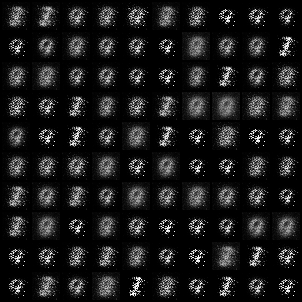

In [27]:
Image('./samples/fake_images-0010.png')

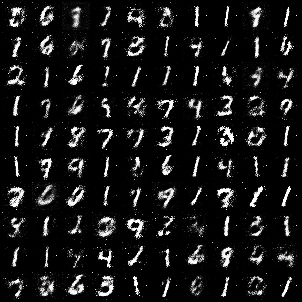

In [28]:
Image('./samples/fake_images-0050.png')

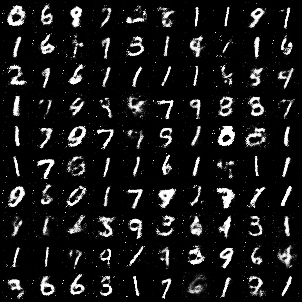

In [29]:
Image('./samples/fake_images-0100.png')

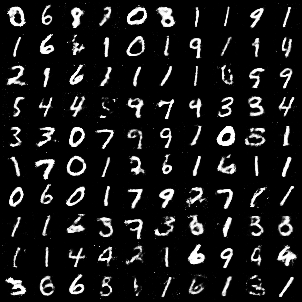

In [30]:
Image('./samples/fake_images-0300.png')

In [31]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

ModuleNotFoundError: No module named 'cv2'